In [2]:
import os
os.chdir("..")

from pprint import pprint
import pickle
from tqdm.notebook import tqdm
from pathlib import Path
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb

from tuxai.dataset import Dataset, Columns
from tuxai.misc import config_logger
from tuxai.report import model_metrics

config_logger()

In [6]:
Dataset(413).get_dataframe(Columns.targets)
#X_train, y_train, X_test, y_test = dataset.train_test_split()

,vmlinux,GZIP-bzImage,GZIP-vmlinux,GZIP,BZIP2-bzImage,BZIP2-vmlinux,BZIP2,LZMA-bzImage,LZMA-vmlinux,LZMA,XZ-bzImage,XZ-vmlinux,XZ,LZO-bzImage,LZO-vmlinux,LZO,LZ4-bzImage,LZ4-vmlinux,LZ4
0,47.895546,7.250931,9.240883,7.060349,11.243118,13.232544,7.125840,5.664993,7.654449,5.482038,4.938431,6.928299,4.749363,8.508743,10.498116,8.329581,9.383743,11.373421,9.192047
1,15.888237,3.919388,5.907341,3.780845,7.782669,9.770096,3.717496,3.231888,5.219345,3.101076,2.708450,4.696320,2.571037,4.310013,6.297386,4.181920,4.614700,6.602379,4.475675
2,41.085106,10.673294,12.661247,10.534802,14.474075,16.461502,10.407073,8.427200,10.414658,8.298181,8.102982,10.090851,7.964371,11.817825,13.805199,11.689056,12.743607,14.731285,12.602777
3,25.998756,7.680618,9.669388,7.540768,11.301712,13.289955,7.233266,6.332962,8.321243,6.203729,6.012650,8.001335,5.871510,8.375931,10.364128,8.246661,8.872025,10.860519,8.731292
4,56.046906,15.387650,17.376419,15.245706,19.090775,21.079018,15.022962,12.118118,14.106400,11.987132,11.750931,13.739616,11.612236,17.102493,19.090691,16.972276,18.450150,20.438644,18.308350
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92557,6.978043,0.616653,2.606560,0.478002,4.503372,6.492752,0.437317,0.534622,2.524033,0.408022,0.526810,2.516632,0.392326,0.659622,2.648949,0.532830,0.690872,2.680504,0.551582
92558,6.978043,0.616653,2.606560,0.478001,4.503372,6.492752,0.437419,0.534622,2.524033,0.407993,0.526810,2.516632,0.392258,0.659622,2.648949,0.532830,0.690872,2.680504,0.551582
92559,6.978043,0.616653,2.606560,0.478003,4.503372,6.492752,0.437265,0.534622,2.524033,0.407948,0.526810,2.516632,0.392273,0.659622,2.648949,0.532830,0.690872,2.680504,0.551582
92560,6.978043,0.616653,2.606560,0.478000,4.503372,6.492752,0.437318,0.534622,2.524033,0.407952,0.526810,2.516632,0.392281,0.659622,2.648949,0.532830,0.690872,2.680504,0.551582


# Feature selection

## Column variance

In [7]:
df = Dataset(413).get_dataframe(Columns.options)
df.var().sort_values()[:50].to_numpy(), df.var().sort_values()[-50:].to_numpy()
# from sklearn.feature_selection import VarianceThreshold

(array([1.08035695e-05, 1.08035695e-05, 1.08035695e-05, 1.08035695e-05,
        1.08035695e-05, 1.08035695e-05, 1.08035695e-05, 1.08035695e-05,
        1.08035695e-05, 1.08035695e-05, 1.08035695e-05, 1.08035695e-05,
        1.08035695e-05, 1.08035695e-05, 1.08035695e-05, 1.08035695e-05,
        1.08035695e-05, 1.08035695e-05, 1.08035695e-05, 1.08035695e-05,
        1.08035695e-05, 1.08035695e-05, 1.08035695e-05, 1.08035695e-05,
        1.08035695e-05, 1.08035695e-05, 1.08035695e-05, 1.08035695e-05,
        1.08035695e-05, 1.08035695e-05, 1.08035695e-05, 1.08035695e-05,
        1.08035695e-05, 1.08035695e-05, 1.08035695e-05, 1.08035695e-05,
        1.08035695e-05, 1.08035695e-05, 1.08035695e-05, 1.08035695e-05,
        1.08035695e-05, 1.08035695e-05, 1.08035695e-05, 1.08035695e-05,
        1.08035695e-05, 1.08035695e-05, 1.08035695e-05, 1.08035695e-05,
        1.08035695e-05, 1.08035695e-05]),
 array([0.25000195, 0.25000195, 0.25000195, 0.25000195, 0.25000195,
        0.25000195, 0.2500

## Columns similarity

In [2]:
from tuxai.featureselection import options_comparison_matrix
options_comparison_matrix(Dataset(413), cache_dir="/data/tuxai/cache", as_dataframe=True)

,OPENVSWITCH,X86_LOCAL_APIC,TEXTSEARCH_FSM,NETFILTER_XT_MATCH_TCPMSS,MPLS,NFC_HCI,NETFILTER_XT_MATCH_TIME,NET_MPLS_GSO,NFC_SHDLC,NETFILTER_XT_MATCH_U32,...,SND_SOC_INTEL_SKL_NAU88L25_SSM4567_MACH,APDS9960,ARCH_SUPPORTS_INT128,SLABINFO,MICROCODE_AMD,ISDN_DRV_HISAX,CHARGER_BQ24190,SND_SOC_NAU8825,BH1750,NETWORK_FILESYSTEMS
X86_LOCAL_APIC,0.109743,NaN,0.084009,0.026793,0.325231,0.124241,0.026415,0.207720,0.105918,0.027484,...,0.020840,0.267237,0.999795,0.410136,0.225913,0.026847,0.373112,0.068376,0.268998,0.244290
TEXTSEARCH_FSM,0.862406,0.084009,NaN,0.923835,0.710853,0.845487,0.922981,0.796515,0.846546,0.923576,...,0.899905,0.704695,0.084214,0.574177,0.727415,0.901547,0.617446,0.863000,0.703799,0.755040
NETFILTER_XT_MATCH_TCPMSS,0.891662,0.026793,0.923835,NaN,0.692574,0.865928,0.977345,0.801722,0.878978,0.977615,...,0.953923,0.724315,0.026998,0.585391,0.759675,0.950811,0.624144,0.910039,0.722726,0.755429
MPLS,0.784512,0.325231,0.710853,0.692574,NaN,0.715780,0.692390,0.882490,0.708649,0.693135,...,0.667542,0.582096,0.325285,0.531871,0.594812,0.683834,0.544500,0.651250,0.580465,0.754132
NFC_HCI,0.839675,0.124241,0.845487,0.865928,0.715780,NaN,0.866457,0.795975,0.894125,0.866273,...,0.863454,0.707763,0.124403,0.568300,0.705722,0.869396,0.626218,0.835926,0.706046,0.753743
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CHARGER_BQ24190,0.619196,0.373112,0.617446,0.624144,0.544500,0.626218,0.624544,0.596454,0.600765,0.624922,...,0.631328,0.638664,0.373123,0.529299,0.570482,0.627871,NaN,0.637746,0.639085,0.564443
SND_SOC_NAU8825,0.843186,0.068376,0.863000,0.910039,0.651250,0.835926,0.910179,0.759966,0.841112,0.909412,...,0.952464,0.724066,0.068581,0.577710,0.736306,0.910590,0.637746,NaN,0.721484,0.721019
BH1750,0.698440,0.268998,0.703799,0.722726,0.580465,0.706046,0.723558,0.658024,0.680895,0.723072,...,0.728485,0.788563,0.269030,0.543830,0.629157,0.724682,0.639085,0.721484,NaN,0.618796
NETWORK_FILESYSTEMS,0.754154,0.244290,0.755040,0.755429,0.754132,0.753743,0.754921,0.753560,0.754132,0.755191,...,0.745003,0.619585,0.244409,0.545353,0.640101,0.755396,0.564443,0.721019,0.618796,NaN


## Correlated features (100%)

In [2]:
from tuxai.featureselection import options_comparison_matrix, correlated_features
cols_matrix = options_comparison_matrix(Dataset(413), cache_dir="/data/tuxai/cache")
correlated_features(cols_matrix)

100%|██████████████████████████████████████████████████████████████████████████| 9467/9467 [00:07<00:00, 1256.19it/s]


[{'GENERIC_CLOCKEVENTS_BROADCAST',
  'IRQ_DOMAIN_HIERARCHY',
  'X86_IO_APIC',
  'X86_LOCAL_APIC'},
 {'TEXTSEARCH_BM', 'TEXTSEARCH_FSM'},
 {'BROKEN_ON_SMP',
  'GENERIC_IRQ_EFFECTIVE_AFF_MASK',
  'GENERIC_IRQ_MIGRATION',
  'GENERIC_PENDING_IRQ',
  'LOCK_SPIN_ON_OWNER',
  'MUTEX_SPIN_ON_OWNER',
  'NEED_PER_CPU_KM',
  'QUEUED_RWLOCKS',
  'QUEUED_SPINLOCKS',
  'RCU_NEED_SEGCBLIST',
  'RCU_STALL_COMMON',
  'RWSEM_SPIN_ON_OWNER',
  'SMP',
  'TINY_RCU',
  'TINY_SRCU',
  'TREE_RCU',
  'TREE_SRCU'},
 {'HAVE_INTEL_TXT', 'INTEL_IOMMU', 'INTEL_IOMMU_FLOPPY_WA'},
 {'ARCH_DMA_ADDR_T_64BIT',
  'ARCH_ENABLE_SPLIT_PMD_PTLOCK',
  'ARCH_PHYS_ADDR_T_64BIT',
  'FLATMEM',
  'FLATMEM_MANUAL',
  'FLAT_NODE_MEM_MAP',
  'HAVE_ARCH_HUGE_VMAP',
  'HAVE_MEMORY_PRESENT',
  'IOMMU_HELPER',
  'M686',
  'PHYS_ADDR_T_64BIT',
  'SPARSEMEM',
  'SPARSEMEM_MANUAL',
  'SWIOTLB'},
 {'EDAC_AMD76X', 'EDAC_E7XXX', 'X86_POWERNOW_K7_ACPI'},
 {'UPROBES', 'UPROBE_EVENTS'},
 {'CLKDEV_LOOKUP',
  'COMMON_CLK',
  'HAVE_CLK',
  'HAVE_CLK

## Check manually

In [3]:
Dataset(413).get_dataframe()[[
    'BROKEN_ON_SMP',
    'GENERIC_IRQ_EFFECTIVE_AFF_MASK',
    'GENERIC_IRQ_MIGRATION',
    'GENERIC_PENDING_IRQ',
    'LOCK_SPIN_ON_OWNER',
    'MUTEX_SPIN_ON_OWNER',
    'NEED_PER_CPU_KM',
    'QUEUED_RWLOCKS',
    'QUEUED_SPINLOCKS',
    'RCU_NEED_SEGCBLIST',
    'RCU_STALL_COMMON',
    'RWSEM_SPIN_ON_OWNER',
    'SMP',
    'TINY_RCU',
    'TINY_SRCU',
    'TREE_RCU',
    'TREE_SRCU'
]]

,BROKEN_ON_SMP,GENERIC_IRQ_EFFECTIVE_AFF_MASK,GENERIC_IRQ_MIGRATION,GENERIC_PENDING_IRQ,LOCK_SPIN_ON_OWNER,MUTEX_SPIN_ON_OWNER,NEED_PER_CPU_KM,QUEUED_RWLOCKS,QUEUED_SPINLOCKS,RCU_NEED_SEGCBLIST,RCU_STALL_COMMON,RWSEM_SPIN_ON_OWNER,SMP,TINY_RCU,TINY_SRCU,TREE_RCU,TREE_SRCU
0,False,True,True,True,True,True,False,True,True,True,True,True,True,False,False,True,True
1,True,False,False,False,False,False,True,False,False,False,False,False,False,True,True,False,False
2,False,True,True,True,True,True,False,True,True,True,True,True,True,False,False,True,True
3,True,False,False,False,False,False,True,False,False,False,False,False,False,True,True,False,False
4,True,False,False,False,False,False,True,False,False,False,False,False,False,True,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92557,True,False,False,False,False,False,True,False,False,False,False,False,False,True,True,False,False
92558,True,False,False,False,False,False,True,False,False,False,False,False,False,True,True,False,False
92559,True,False,False,False,False,False,True,False,False,False,False,False,False,True,True,False,False
92560,True,False,False,False,False,False,True,False,False,False,False,False,False,True,True,False,False


## Test with threshold >0

In [4]:
from tuxai.featureselection import options_comparison_matrix, correlated_features
cols_matrix = options_comparison_matrix(Dataset(413), cache_dir="/data/tuxai/cache")
filtered_options = dict()
for th in tqdm(np.arange(0, 0.01, 0.001)):
    groups = correlated_features(cols_matrix, th)
    filtered_options[th] = sum((len(group) - 1) for group in groups)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/9467 [00:00<?, ?it/s]

  0%|          | 0/9467 [00:00<?, ?it/s]

  0%|          | 0/9467 [00:00<?, ?it/s]

  0%|          | 0/9467 [00:00<?, ?it/s]

  0%|          | 0/9467 [00:00<?, ?it/s]

  0%|          | 0/9467 [00:00<?, ?it/s]

  0%|          | 0/9467 [00:00<?, ?it/s]

  0%|          | 0/9467 [00:00<?, ?it/s]

  0%|          | 0/9467 [00:00<?, ?it/s]

  0%|          | 0/9467 [00:00<?, ?it/s]

In [5]:
filtered_options

{0.0: 570,
 0.001: 780,
 0.002: 829,
 0.003: 918,
 0.004: 1028,
 0.005: 1112,
 0.006: 1220,
 0.007: 1276,
 0.008: 1316,
 0.009000000000000001: 1391}

In [6]:
df = pd.DataFrame.from_dict(filtered_options, orient='index', columns=["filtered"])
df = df.reset_index()
df = df.rename(columns={"index": "pct"})
df.pct = 100 * (1 - df.pct)
df

,pct,filtered
0,100.0,570
1,99.9,780
2,99.8,829
3,99.7,918
4,99.6,1028
5,99.5,1112
6,99.4,1220
7,99.3,1276
8,99.2,1316
9,99.1,1391


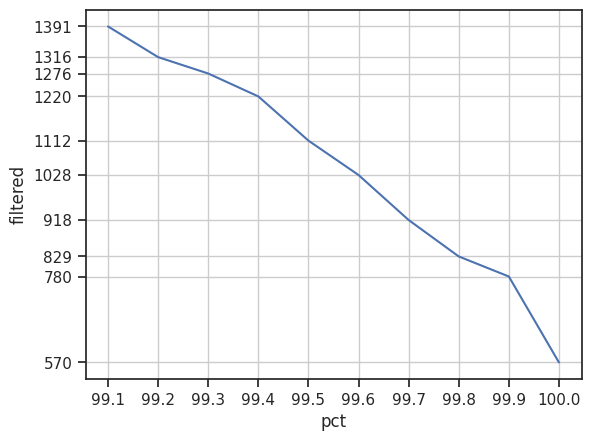

In [7]:
sns.set(style="ticks")
sns.lineplot(data=df, x="pct", y="filtered")
plt.xticks(df["pct"])
plt.yticks(df["filtered"])
plt.grid()

# XGBOOST with MAPE instead of RMSE

In [30]:
X_train, y_train, X_test, y_test = tuxai_train_test_split(413)

params = {
    "max_depth": 5,
    "alpha": 10,
    "learning_rate": 0.1,
    "n_estimators":100,
    "eval_metric": "mape"
}

xgb_reg = xgb.XGBRegressor(**params)
xgb_reg.fit(X_train, y_train)
y_pred = xgb_reg.predict(X_test)

{'d2 absolute error score': 0.8318630231953474,
 'd2 pinball score': 0.8318630231953474,
 'd2 tweedie score': 0.9624204134832633,
 'explained variance score': 0.9624217120051763,
 'max error': 545.475456237793,
 'mean absolute error': 4.444298262618797,
 'mean absolute percentage error': 0.08116643178435545,
 'mean gamma deviance': 0.013379570763104384,
 'mean pinball loss': 2.2221491313093984,
 'mean poisson deviance': 0.7528403478206792,
 'mean squared error': 178.68663835254551,
 'mean squared log error': 0.01126257536496038,
 'mean tweedie deviance': 178.68663835254551,
 'r2 score': 0.9624204134832633,
 'root mean squared error': 13.367372155833229}


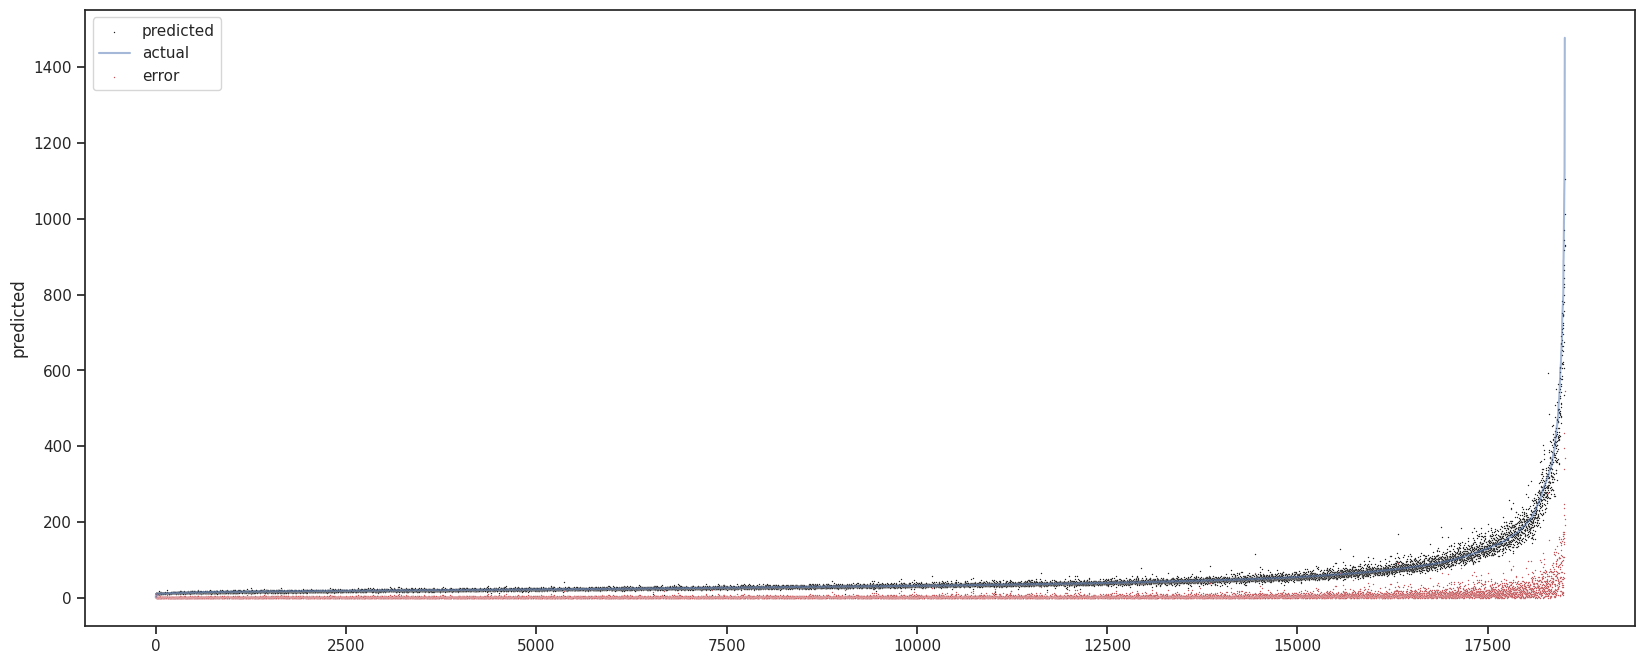

In [31]:
pprint(report(y_pred, y_test))
plot_pred_true(y_pred, y_test)

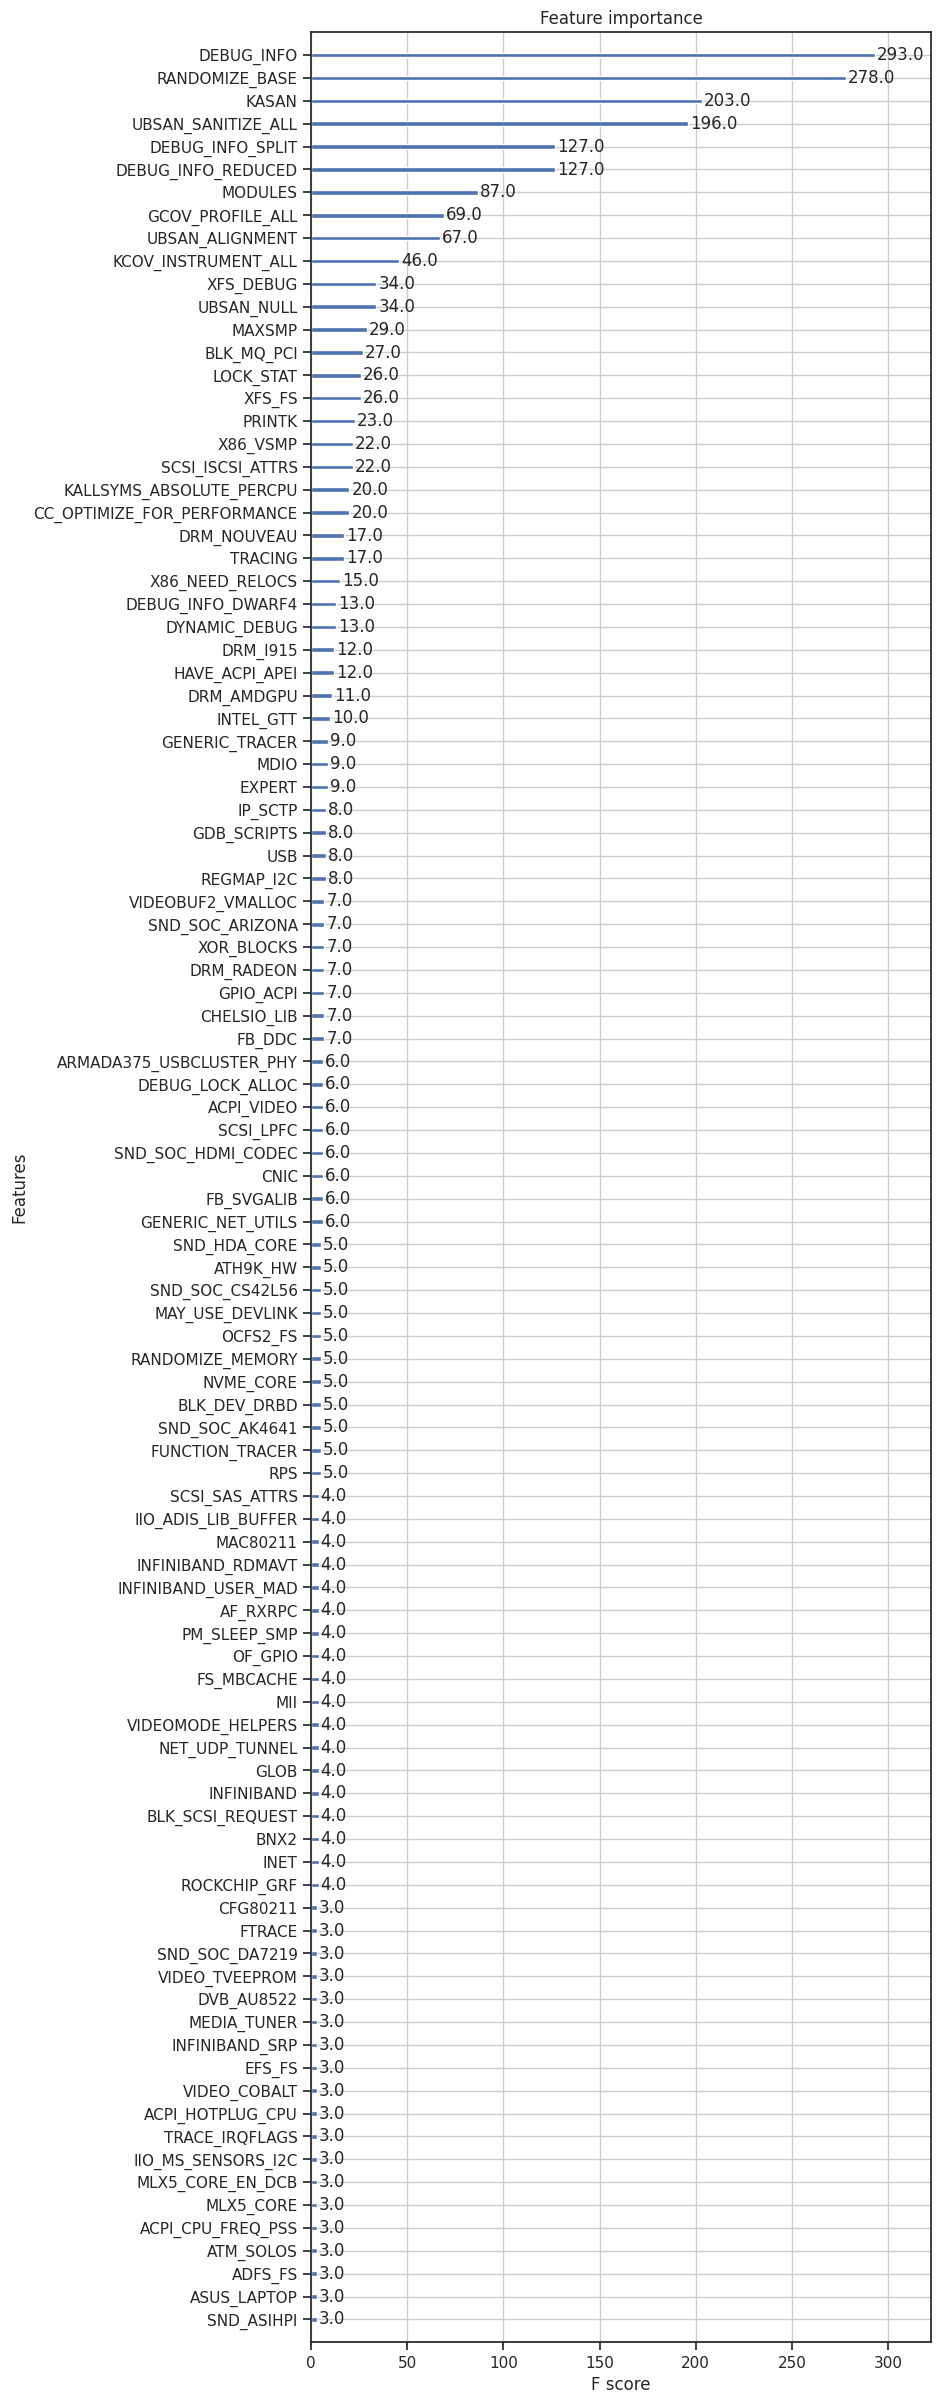

In [37]:
xgb.plot_importance(xgb_reg, max_num_features=100)
fig = plt.gcf()
fig.set_size_inches(8,30)

# Remove same features
## MAPE: from 0.81166 to 0.081643

  0%|          | 0/9467 [00:00<?, ?it/s]

570 columns dropped
{'d2 absolute error score': 0.8284037521017104,
 'd2 pinball score': 0.8284037521017104,
 'd2 tweedie score': 0.9620039819361995,
 'explained variance score': 0.962005482959859,
 'max error': 464.21158599853516,
 'mean absolute error': 4.34754678739796,
 'mean absolute percentage error': 0.08164384106784706,
 'mean gamma deviance': 0.012096165806786532,
 'mean pinball loss': 2.17377339369898,
 'mean poisson deviance': 0.7325203003643259,
 'mean squared error': 163.4847366585608,
 'mean tweedie deviance': 163.4847366585608,
 'r2 score': 0.9620039819361995,
 'root mean squared error': 12.786114994733968}


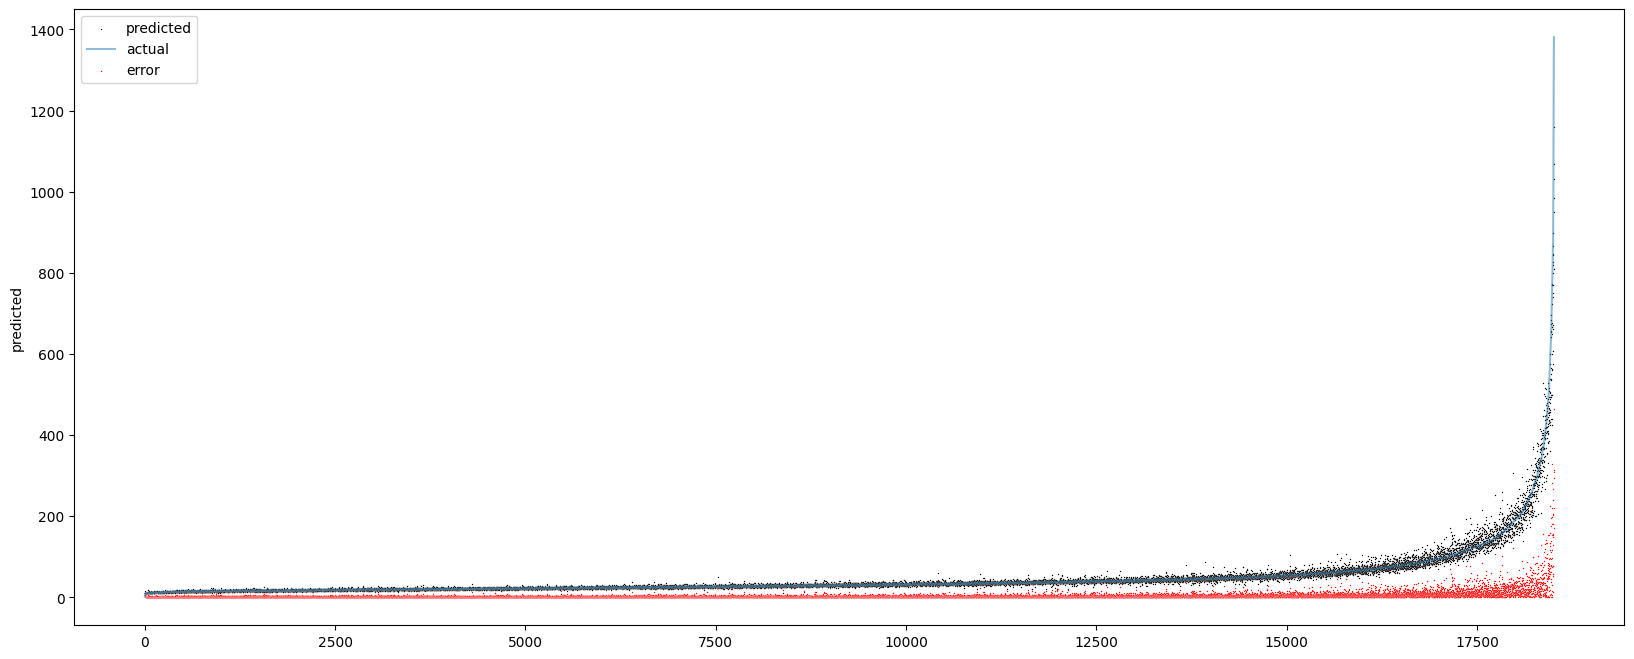

In [7]:
# test again
X_train, y_train, X_test, y_test = tuxai_train_test_split(413)

# 100% same groups
groups = make_groups(col_sims, 0)
to_drop = set()
for group in groups:
    # remove one
    group.pop()
    # add others
    to_drop.update(group)

before = len(X_train.columns)
X_train = X_train.drop(columns=to_drop)
X_test = X_test.drop(columns=to_drop)
print(f"{before - len(X_train.columns)} columns dropped")

params = {
    "max_depth": 5,
    "alpha": 10,
    "learning_rate": 0.1,
    "n_estimators":100,
    "eval_metric": "mape"
}

xgb_reg = xgb.XGBRegressor(**params)
xgb_reg.fit(X_train, y_train)
y_pred = xgb_reg.predict(X_test)

pprint(report(y_pred, y_test))
plot_pred_true(y_pred, y_test)


  0%|          | 0/9467 [00:00<?, ?it/s]

1463 columns dropped
{'d2 absolute error score': 0.8294860928524843,
 'd2 pinball score': 0.8294860928524843,
 'd2 tweedie score': 0.9640587751972743,
 'explained variance score': 0.9640590208385318,
 'max error': 369.9805679321289,
 'mean absolute error': 4.398335523197873,
 'mean absolute percentage error': 0.08097409029942483,
 'mean gamma deviance': 0.011837013447199105,
 'mean pinball loss': 2.1991677615989365,
 'mean poisson deviance': 0.7425148773734711,
 'mean squared error': 169.70528561248972,
 'mean tweedie deviance': 169.70528561248972,
 'r2 score': 0.9640587751972743,
 'root mean squared error': 13.02709812707687}


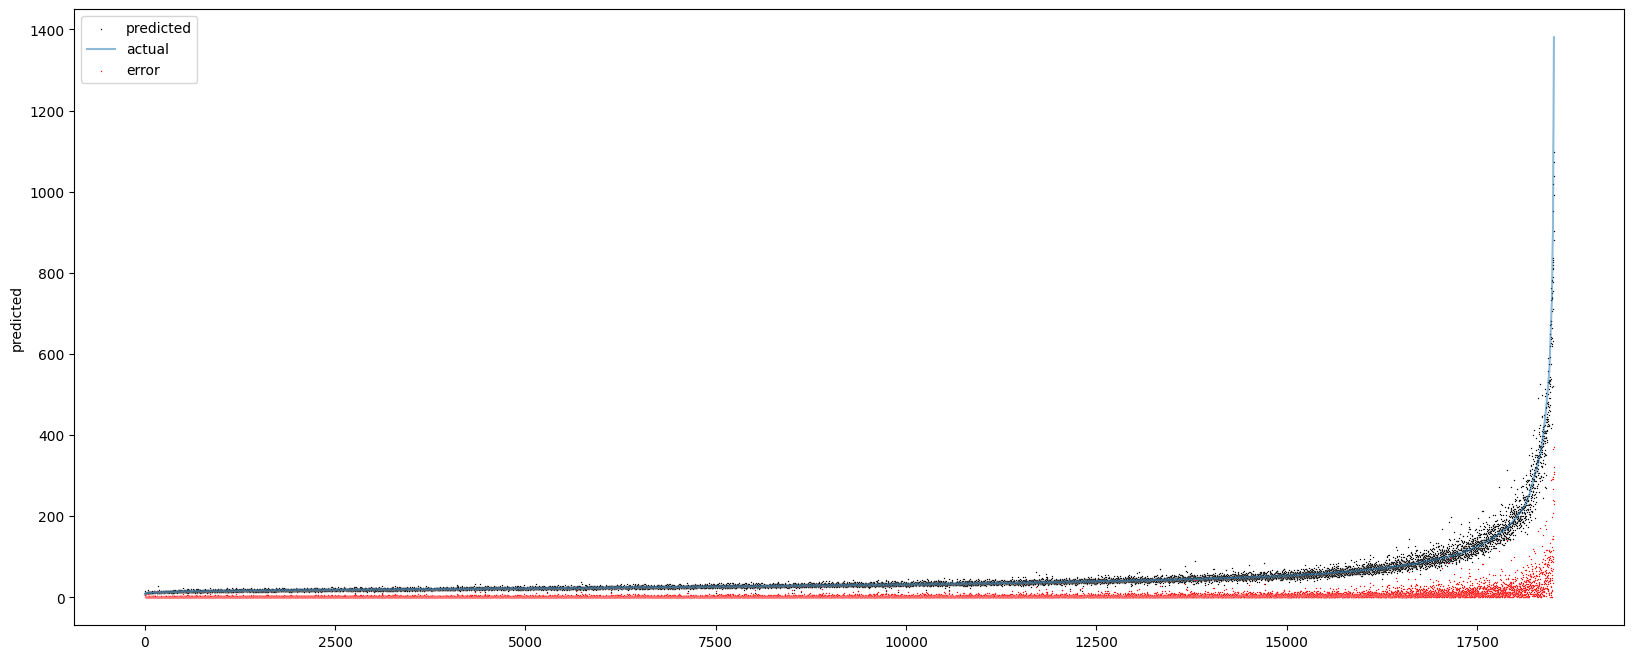

In [8]:
# test again
X_train, y_train, X_test, y_test = tuxai_train_test_split(413)

# 99% same groups
groups = make_groups(col_sims, 0.01)
to_drop = set()
for group in groups:
    # remove one
    group.pop()
    # add others
    to_drop.update(group)

before = len(X_train.columns)
X_train = X_train.drop(columns=to_drop)
X_test = X_test.drop(columns=to_drop)
print(f"{before - len(X_train.columns)} columns dropped")

params = {
    "max_depth": 5,
    "alpha": 10,
    "learning_rate": 0.1,
    "n_estimators":100,
    "eval_metric": "mape"
}

xgb_reg = xgb.XGBRegressor(**params)
xgb_reg.fit(X_train, y_train)
y_pred = xgb_reg.predict(X_test)

pprint(report(y_pred, y_test))
plot_pred_true(y_pred, y_test)